<a href="https://colab.research.google.com/github/maraghy96/Object-Localization/blob/main/Copy_of_Deep_Learning_with_PyTorch_Object_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro Task, Object Localization

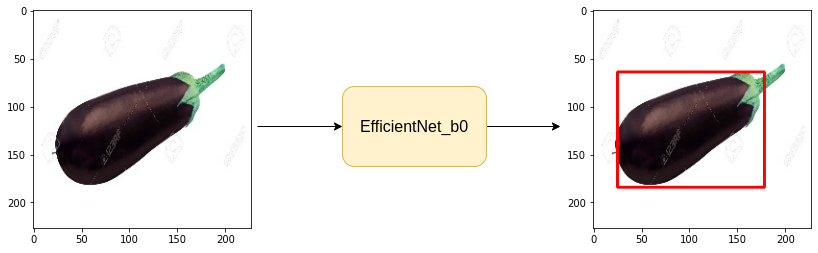

In [43]:
# install libraries/packages/modules

!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-y5f6prtx
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-y5f6prtx
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
# Download Dataset

!git clone https://github.com/parth1620/object-localization-dataset.git

fatal: destination path 'object-localization-dataset' already exists and is not an empty directory.


In [45]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [46]:
import sys
sys.path.append('/content/object-localization-dataset')

# Configurations

In [85]:
CSV_FILE = '/content/object-localization-dataset/train.csv'
DATA_DIR = '/content/object-localization-dataset/'


DEVICE = 'cuda'
BATCH_SIZE = 16
IMG_SIZE = 140

LR=0.001
EPOCHS = 40
MODEL_NAME = 'resnet50'
NUM_COR = 4


In [48]:
df = pd.read_csv(CSV_FILE)
df

,img_path,xmin,ymin,xmax,ymax,width,height,label
0,train_images/mushroom_51.jpg,24,23,202,183,227,227,mushroom
1,train_images/eggplant_37.jpg,34,34,88,201,227,227,eggplant
2,train_images/mushroom_20.jpg,49,86,183,185,227,227,mushroom
3,train_images/eggplant_51.jpg,51,59,191,164,227,227,eggplant
4,train_images/eggplant_26.jpg,40,70,179,168,227,227,eggplant
...,...,...,...,...,...,...,...,...
181,train_images/eggplant_62.jpg,67,22,177,215,227,227,eggplant
182,train_images/cucumber_45.jpg,11,31,217,208,227,227,cucumber
183,train_images/mushroom_37.jpg,93,13,158,193,227,227,mushroom
184,train_images/eggplant_44.jpg,21,59,192,171,227,227,eggplant


# Understand the dataset

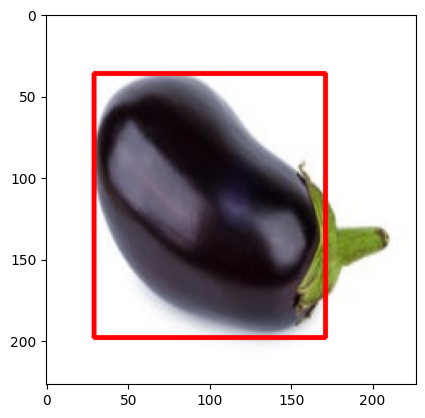

In [49]:
row = df.iloc[12]
img = cv2.imread(DATA_DIR + row.img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pt1= (row.xmin, row.ymin)
pt2= (row.xmax, row.ymax)
bnd_box_img = cv2.rectangle(img,pt1,pt2,(255, 0, 0), 2)


plt.imshow(img)

In [50]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Augmentations

In [51]:
import albumentations as A

In [52]:
import albumentations as A
#Augmantation for detection task
train_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate()
], bbox_params=A.BboxParams( format = 'pascal_voc', label_fields = ['class_labels']))

valid_augs = A.Compose([
    A.Resize(IMG_SIZE,IMG_SIZE),
], bbox_params=A.BboxParams( format = 'pascal_voc', label_fields = ['class_labels']))

# Create Custom Dataset

In [53]:
from pandas.core.describe import describe_categorical_1d
class ObjectLocDataset(torch.utils.data.Dataset):

    def __init__(self, df, augmentations = None):
      self.df= df
      self.augmentations = augmentations

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):

        row = self.df.iloc[idx]

        xmin = row.xmin
        ymin = row.ymin
        xmax = row.xmax
        ymax = row.ymax

        bbox = [[xmin, ymin, xmax, ymax]]

        img_path = DATA_DIR + row.img_path
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.augmentations:
          data = self.augmentations(image = img, bboxes = bbox, class_labels = [None])
          img = data['image']
          bbox = data ['bboxes'][0]

        img = (torch.from_numpy(img).permute(2,0,1)/255.0) #(h, w, c) -> (c, h, w)
        bbox = torch.Tensor(bbox)

        return img, bbox

In [54]:
trainset = ObjectLocDataset(train_df, train_augs)
validset = ObjectLocDataset(valid_df, valid_augs)

In [55]:
print(f"Total examples in the trainset: {len(trainset)}")
print(f"Total examples in the Validset: {len(validset)}")

Total examples in the trainset: 148
Total examples in the Validset: 38


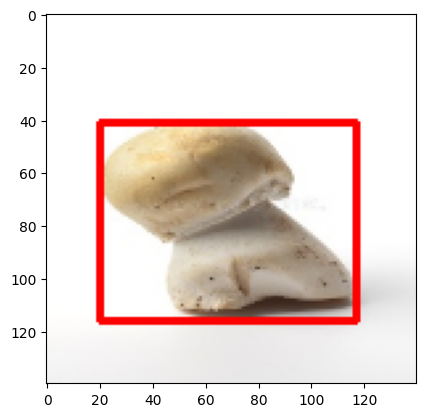

In [56]:
img, bbox = trainset[55]

xmin, ymin, xmax, ymax = bbox

pt1 = (int(xmin), int(ymin))
pt2 = (int(xmax), int(ymax))

bnd_img = cv2.rectangle(img.permute(1, 2, 0).numpy(),pt1, pt2,(255,0,0),2)
plt.imshow(bnd_img)

# Load dataset into batches

In [57]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size= BATCH_SIZE, shuffle=True)
validloader = torch.utils.data.DataLoader(validset, batch_size= BATCH_SIZE, shuffle=False)

In [58]:
print("Total no. batches in trainloader : {}".format(len(trainloader)))
print("Total no. batches in validloader : {}".format(len(validloader)))

Total no. batches in trainloader : 10
Total no. batches in validloader : 3


In [59]:
for images, bboxes in trainloader:
  break;


print("Shape of one batch images : {}".format(images.shape))
print("Shape of one batch bboxes : {}".format(bboxes.shape))

Shape of one batch images : torch.Size([16, 3, 140, 140])
Shape of one batch bboxes : torch.Size([16, 4])


# Create Model

In [60]:
from torch import nn
import timm

In [41]:
class ObjLocModel(nn.Module):

  def __init__(self):
      super(ObjLocModel, self).__init__()
      self.backbone = timm.create_model(MODEL_NAME, pretrained= True, num_classes= 4)

  def  forward(self, images, gt_bboxes= None):

       bboxes = self.backbone(images)

       if gt_bboxes != None:
          loss = nn.MSELoss()(bboxes, gt_bboxes)
          return bboxes, loss

       return bboxes

In [63]:
model = ObjLocModel()
model.to(DEVICE)

ObjLocModel(
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(

# Create Train and Eval Function

In [87]:
def train_fn(model, dataloader, optimizer):
    total_loss = 0.0
    model.train() #Dropout on

    for data in tqdm(dataloader):

        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss/ len(dataloader)


In [88]:
def eval_fn(model, dataloader):
    total_loss = 0.0
    model.eval() #Dropout on

    for data in tqdm(dataloader):

        images, gt_bboxes = data
        images, gt_bboxes = images.to(DEVICE), gt_bboxes.to(DEVICE)

        bboxes, loss = model(images, gt_bboxes)
        total_loss += loss.item()

    return total_loss/ len(dataloader)


#Training Loop

In [89]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [90]:
best_valid_loss= np.Inf

for i in range(EPOCHS):

    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
       torch.save(model.state_dict(), 'best_model.pt')
       print("Weights are saved")
       best_valid_loss = valid_loss

    print(f"Epoch : {i + 1} train loss: {train_loss} valid loss: {valid_loss}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 1 train loss: 97.90724182128906 valid loss: 161.52486419677734


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 2 train loss: 79.45083618164062 valid loss: 134.71422576904297


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 3 train loss: 96.56005935668945 valid loss: 107.1806411743164


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 4 train loss: 65.51593475341797 valid loss: 95.2189229329427


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 5 train loss: 61.097761154174805 valid loss: 132.12574259440103


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 6 train loss: 72.01271362304688 valid loss: 82.39314524332683


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 7 train loss: 60.50510749816895 valid loss: 104.84347534179688


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 8 train loss: 45.20315589904785 valid loss: 83.56742604573567


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 9 train loss: 45.57649402618408 valid loss: 69.48251215616862


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 10 train loss: 57.35010166168213 valid loss: 117.16150665283203


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 11 train loss: 36.54631652832031 valid loss: 90.81854756673177


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 12 train loss: 44.1287956237793 valid loss: 120.88187154134114


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 13 train loss: 48.71616706848145 valid loss: 77.89040883382161


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 14 train loss: 46.589111518859866 valid loss: 68.14840189615886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 15 train loss: 43.83941860198975 valid loss: 70.2087173461914


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 16 train loss: 45.81458435058594 valid loss: 86.53631337483723


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 17 train loss: 39.40247402191162 valid loss: 95.88180033365886


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 18 train loss: 47.67287940979004 valid loss: 89.15852610270183


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 19 train loss: 40.776733779907225 valid loss: 85.11351013183594


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 20 train loss: 43.932271575927736 valid loss: 132.2051773071289


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 21 train loss: 54.723118209838866 valid loss: 196.86771138509116


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 22 train loss: 45.74161586761475 valid loss: 151.12876637776694


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 23 train loss: 44.881392097473146 valid loss: 117.57777786254883


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 24 train loss: 38.86198539733887 valid loss: 67.79573822021484


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 25 train loss: 40.8505256652832 valid loss: 117.61035410563152


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 26 train loss: 59.874057579040525 valid loss: 71.94993082682292


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 27 train loss: 39.70898361206055 valid loss: 76.88267262776692


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 28 train loss: 35.42383651733398 valid loss: 113.26669565836589


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Weights are saved
Epoch : 29 train loss: 33.09092559814453 valid loss: 62.82191721598307


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 30 train loss: 37.57885141372681 valid loss: 72.9093500773112


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 31 train loss: 37.042289066314694 valid loss: 93.0386962890625


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 32 train loss: 33.89861660003662 valid loss: 89.2151387532552


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 33 train loss: 39.69667739868164 valid loss: 87.91943105061848


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 34 train loss: 35.39026794433594 valid loss: 73.08774058024089


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 35 train loss: 33.58408393859863 valid loss: 65.24123636881511


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 36 train loss: 41.85320339202881 valid loss: 75.28122965494792


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 37 train loss: 34.029616355895996 valid loss: 108.20538584391277


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 38 train loss: 46.079238700866696 valid loss: 158.63251241048178


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 39 train loss: 36.44871158599854 valid loss: 66.60877863566081


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 40 train loss: 31.706719970703126 valid loss: 74.70580037434895


#Inference

In [80]:
import utils

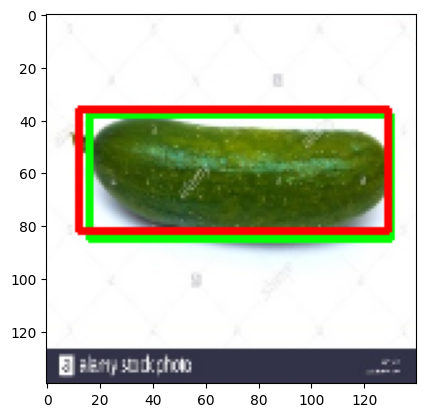

In [86]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


with torch.no_grad():

      image, gt_bboxes = validset[8]  #(c, h, w)
      image = image.unsqueeze(0).to(DEVICE)
      out_bbox = model(image)


      utils.compare_plots(image, gt_bboxes, out_bbox)